In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as stfu
import numpy as np
from scipy.linalg import qr
from math import ceil
from utils import weighted_ls, detect_outliers, find_component, MixIRLS_inner
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
stfu.filterwarnings('ignore')

## California Housing

In [28]:
california = pd.read_csv('data/california.csv')
california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<Axes: xlabel='MedHouseVal', ylabel='Density'>

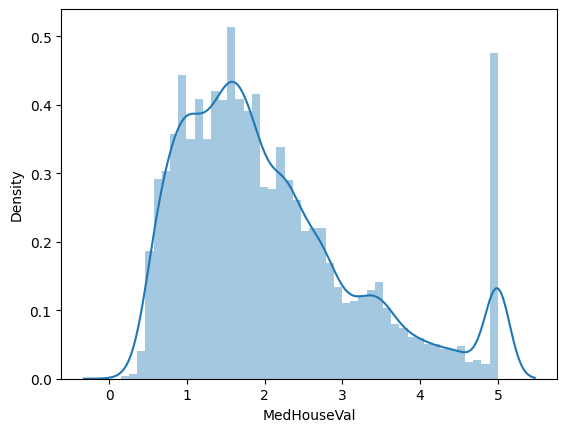

In [29]:
sns.distplot(california['MedHouseVal'])

## Insurance cost

In [30]:
insurance = pd.read_csv('data/insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<Axes: xlabel='charges', ylabel='Density'>

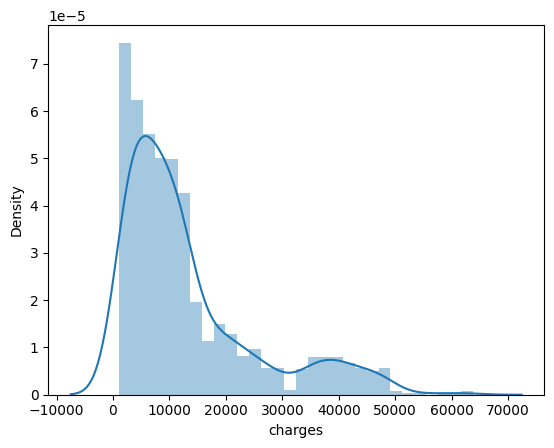

In [31]:
sns.distplot(insurance['charges'])

## Fish weight prediction

In [32]:
fish = pd.read_csv('data/fish.csv')
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


<Axes: xlabel='Weight', ylabel='Density'>

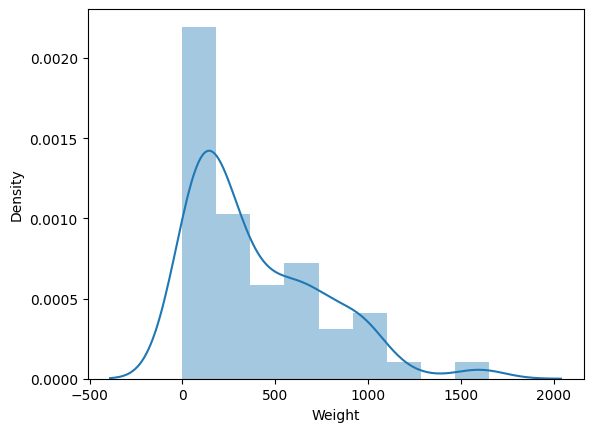

In [33]:
sns.distplot(fish['Weight'])

## Mix-IRLS implementation

In [48]:
class MixIRLSRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, beta_init, opts_input={}):
        self.beta_init = beta_init
        self.opts_input = opts_input
        self.beta_hat = None
        self.iter = None

    def fit(self, X, y):
        self.beta_hat, self.iter = self._MixIRLS(X, y, self.beta_init, self.opts_input)
        return self

    def predict(self, X):
        return X @ self.beta_hat

    def _MixIRLS(self, X, y, beta_init, opts_input={}):
        opts = dict()
        opts['verbose'] = False # let MixIRLS chat
        opts['T1'] = int(1e3) # phase I inner IRLS maximal number of iterations
        opts['T2'] = int(1e3) # phase II maximal number of iterations
        opts['wfun'] = lambda r: 1 / (1 + r**2) # IRLS function
        opts['rho'] = 2. # oversampling parameter. Set to 2 in real-data experiments
        opts['nu'] = 1 # tuning parameter. Set to 1 in real-data experiments
        opts['w_th_init'] = 0.1 # initialization for threshold parameter w_th
        opts['corrupt_frac'] = 0 # fraction of outliers
        opts['unknownK'] = True # if true, assumes K is unknown
        opts['tol'] = 2e-16 # tolerance for stopping criterion
        opts['errfun'] = lambda beta_hat: -1 # error function (unknown by default). Used only if verbose is on
        
        for key in opts_input.keys():
            opts[key] = opts_input[key]

        ## set parameters
        n, d = X.shape
        K = beta_init.shape[1]
        verbose = opts['verbose']
        
        beta_hat = np.zeros((d,K))
        supports = np.ones((n,K), dtype=np.bool8)
        w_th = opts['w_th_init']
        first_component_w = np.zeros_like(y)

        iter = 0
        k = 0
        while k < K:
            curr_X = X[supports[:,k],:]
            curr_y = y[supports[:,k]]

            if k==0 and np.any(first_component_w):
                if verbose:
                    print('use same component 1')
                w = first_component_w
                beta_hat[:, 1:] = 0
            else:
                if verbose:
                    print('find component ' + str(k+1))

                [beta, w, inner_iter] = find_component(curr_X, curr_y, opts['wfun'], \
                    opts['nu'], opts['rho'], opts['T1'], beta_init[:,k], verbose)
                iter = iter + inner_iter

                beta_hat[:,k]= beta
                if k==0: 
                    first_component_w = w
            
            next_oversampling = max(0, np.count_nonzero(w <= w_th) - opts['corrupt_frac'] * n) / d
            if not opts['unknownK'] and (k < K-1) and (next_oversampling < opts['rho']):
                if verbose:
                    print('w_th ' + str(w_th) + ' is too low! Starting over...')
                w_th = w_th + 0.1
                k = 0
                continue
            else:
                new_support = supports[:, k].copy()
                new_support[new_support] = (w <= w_th)
                if k < K-1:
                    supports[:, k+1] = new_support

            if verbose:
                print('MixIRLS. error: ' + '{:.3e}'.format(opts['errfun'](beta_hat)) + ', \tk: ' + str(k+1))

            if opts['unknownK'] and (next_oversampling < opts['rho']):
                K = k+1
                beta_hat = beta_hat[:, :K]
                if verbose:
                    print('MixIRLS. found K=' + str(K) + ' components, stopping here')
                break

            k = k + 1

        beta_diff = 1
        iter_phase2 = 0
        while (beta_diff > opts['tol']) and (iter_phase2 < opts['T2']):
            beta_hat_prev = beta_hat
            res2 = np.zeros((len(y), K))
            for k in range(K):
                res2[:, k] = abs(X @ beta_hat[:, k] - y)**2

            w = 1 / (res2 + 1e-16)
            w = w / np.sum(w + 1e-16, axis=1)[:, np.newaxis]
            highs = np.any(w>=2/3, axis=1)
            w_highs = w[highs,:]
            w_highs[w_highs>=2/3] = 1
            w_highs[w_highs<2/3] = 0
            w[highs,:] = w_highs
            lows = np.any(w<1/K, axis=1)
            w_lows = w[lows,:]
            w_lows[w_lows<1/K] = 0
            w[lows,:] = w_lows
            w = w / np.sum(w + 1e-16, axis=1)[:, np.newaxis]

            outlier_indicator = detect_outliers(res2, opts['corrupt_frac'])
            samples_to_use = ~outlier_indicator

            for k in range(K):
                    beta_hat[:, k] = weighted_ls(X[samples_to_use,:], y[samples_to_use], w[samples_to_use,k])
            beta_diff = np.linalg.norm(beta_hat - beta_hat_prev, 'fro') / np.linalg.norm(beta_hat, 'fro')
    
            iter_phase2 = iter_phase2 + 1
            if verbose and (iter_phase2 % 10 == 0):
                print('Mix-IRLS. error: ' + '{:.3e}'.format(opts['errfun'](beta_hat)) + ', \tphase2-iter: ' + str(iter_phase2))
        
        iter = iter + iter_phase2
        return beta_hat, iter

In [53]:
def compare(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    linear_regressor = LinearRegression()
    mirls_regressor = MixIRLSRegressor(beta_init = np.random.rand(X.shape[1], 2))

    linear_regressor.fit(X_train, y_train)
    mirls_regressor.fit(X_train, y_train)

    linear_pred = linear_regressor.predict(X_test)
    mirls_pred = mirls_regressor.predict(X_test)

    linear_mse = mean_squared_error(y_test, linear_pred)
    mirls_mse = mean_squared_error(y_test, mirls_pred)

    print(f"Linear MSE: {linear_mse}, r2: {r2_score(y_test, linear_pred)}")
    print(f"MIRLS MSE: {mirls_mse}, r2: {r2_score(y_test, mirls_pred)}")

    plt.scatter(y_test, linear_pred, color='blue')
    plt.scatter(y_test, mirls_pred, color='red')
    plt.show()    

In [54]:
y = california['MedHouseVal']
X = california.drop('MedHouseVal', axis=1)
compare(X, y)

InvalidIndexError: (array([ True,  True,  True, ...,  True,  True,  True]), slice(None, None, None))